# Comparing methods of hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model, build_mcdrop_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp

silence_tensorflow()

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "19 January 2022"

EXP_NAME_LIST = (
                 # "intensity14_EPCP72",
                 # "intensity16_EPCP72",    
                 # "intensity17_EPCP72",    
                 # "intensity18_EPCP72",        
                  "intensity19_EPCP72",
                )

# EXP_NAME_LIST = (
#                  "intensity8_AL96",
#                  "intensity9_AL96",
#                  "intensity10_EPCP96",
#                  "intensity11_EPCP96",
#                  "intensity12_AL48",
#                  "intensity13_AL48",    
#                 )

# EXP_NAME_LIST = (
#                  "intensity200_EPCP48",
#                  "intensity201_EPCP48",
#                  "intensity202_EPCP72",
#                  "intensity203_EPCP72",
#                  "intensity204_AL72",
#                  "intensity205_AL72",
#                  "intensity206_AL48",
#                  "intensity207_AL48",
#                 )

OVERWRITE_MODEL = False
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Start looping through random seeds

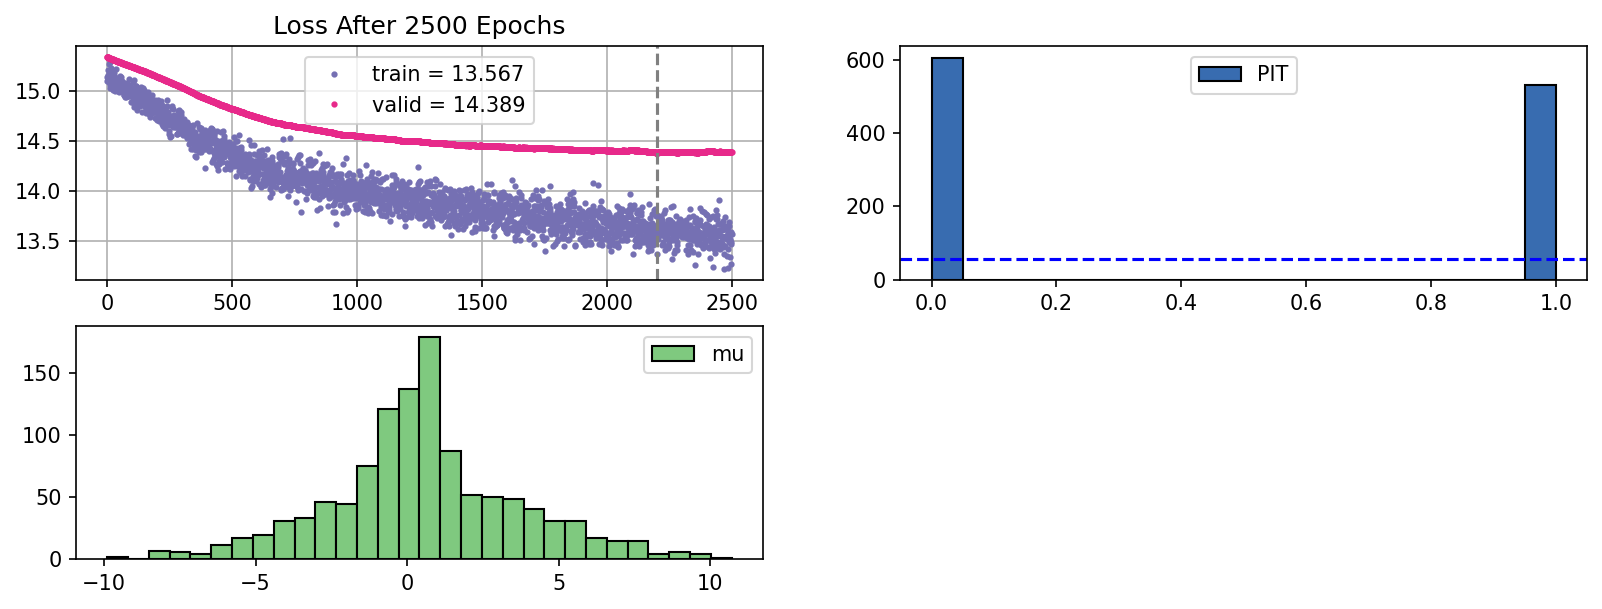

Epoch 02501: early stopping
{'best_epoch': 2200,
 'elapsed_time': 83.76694774627686,
 'loss_train': 13.748933792114258,
 'loss_valid': 14.38443374633789,
 'network_seed': 444}
no mae metric, skipping plot
no interquartile_capture, skipping plot
no sign-test, skipping plot


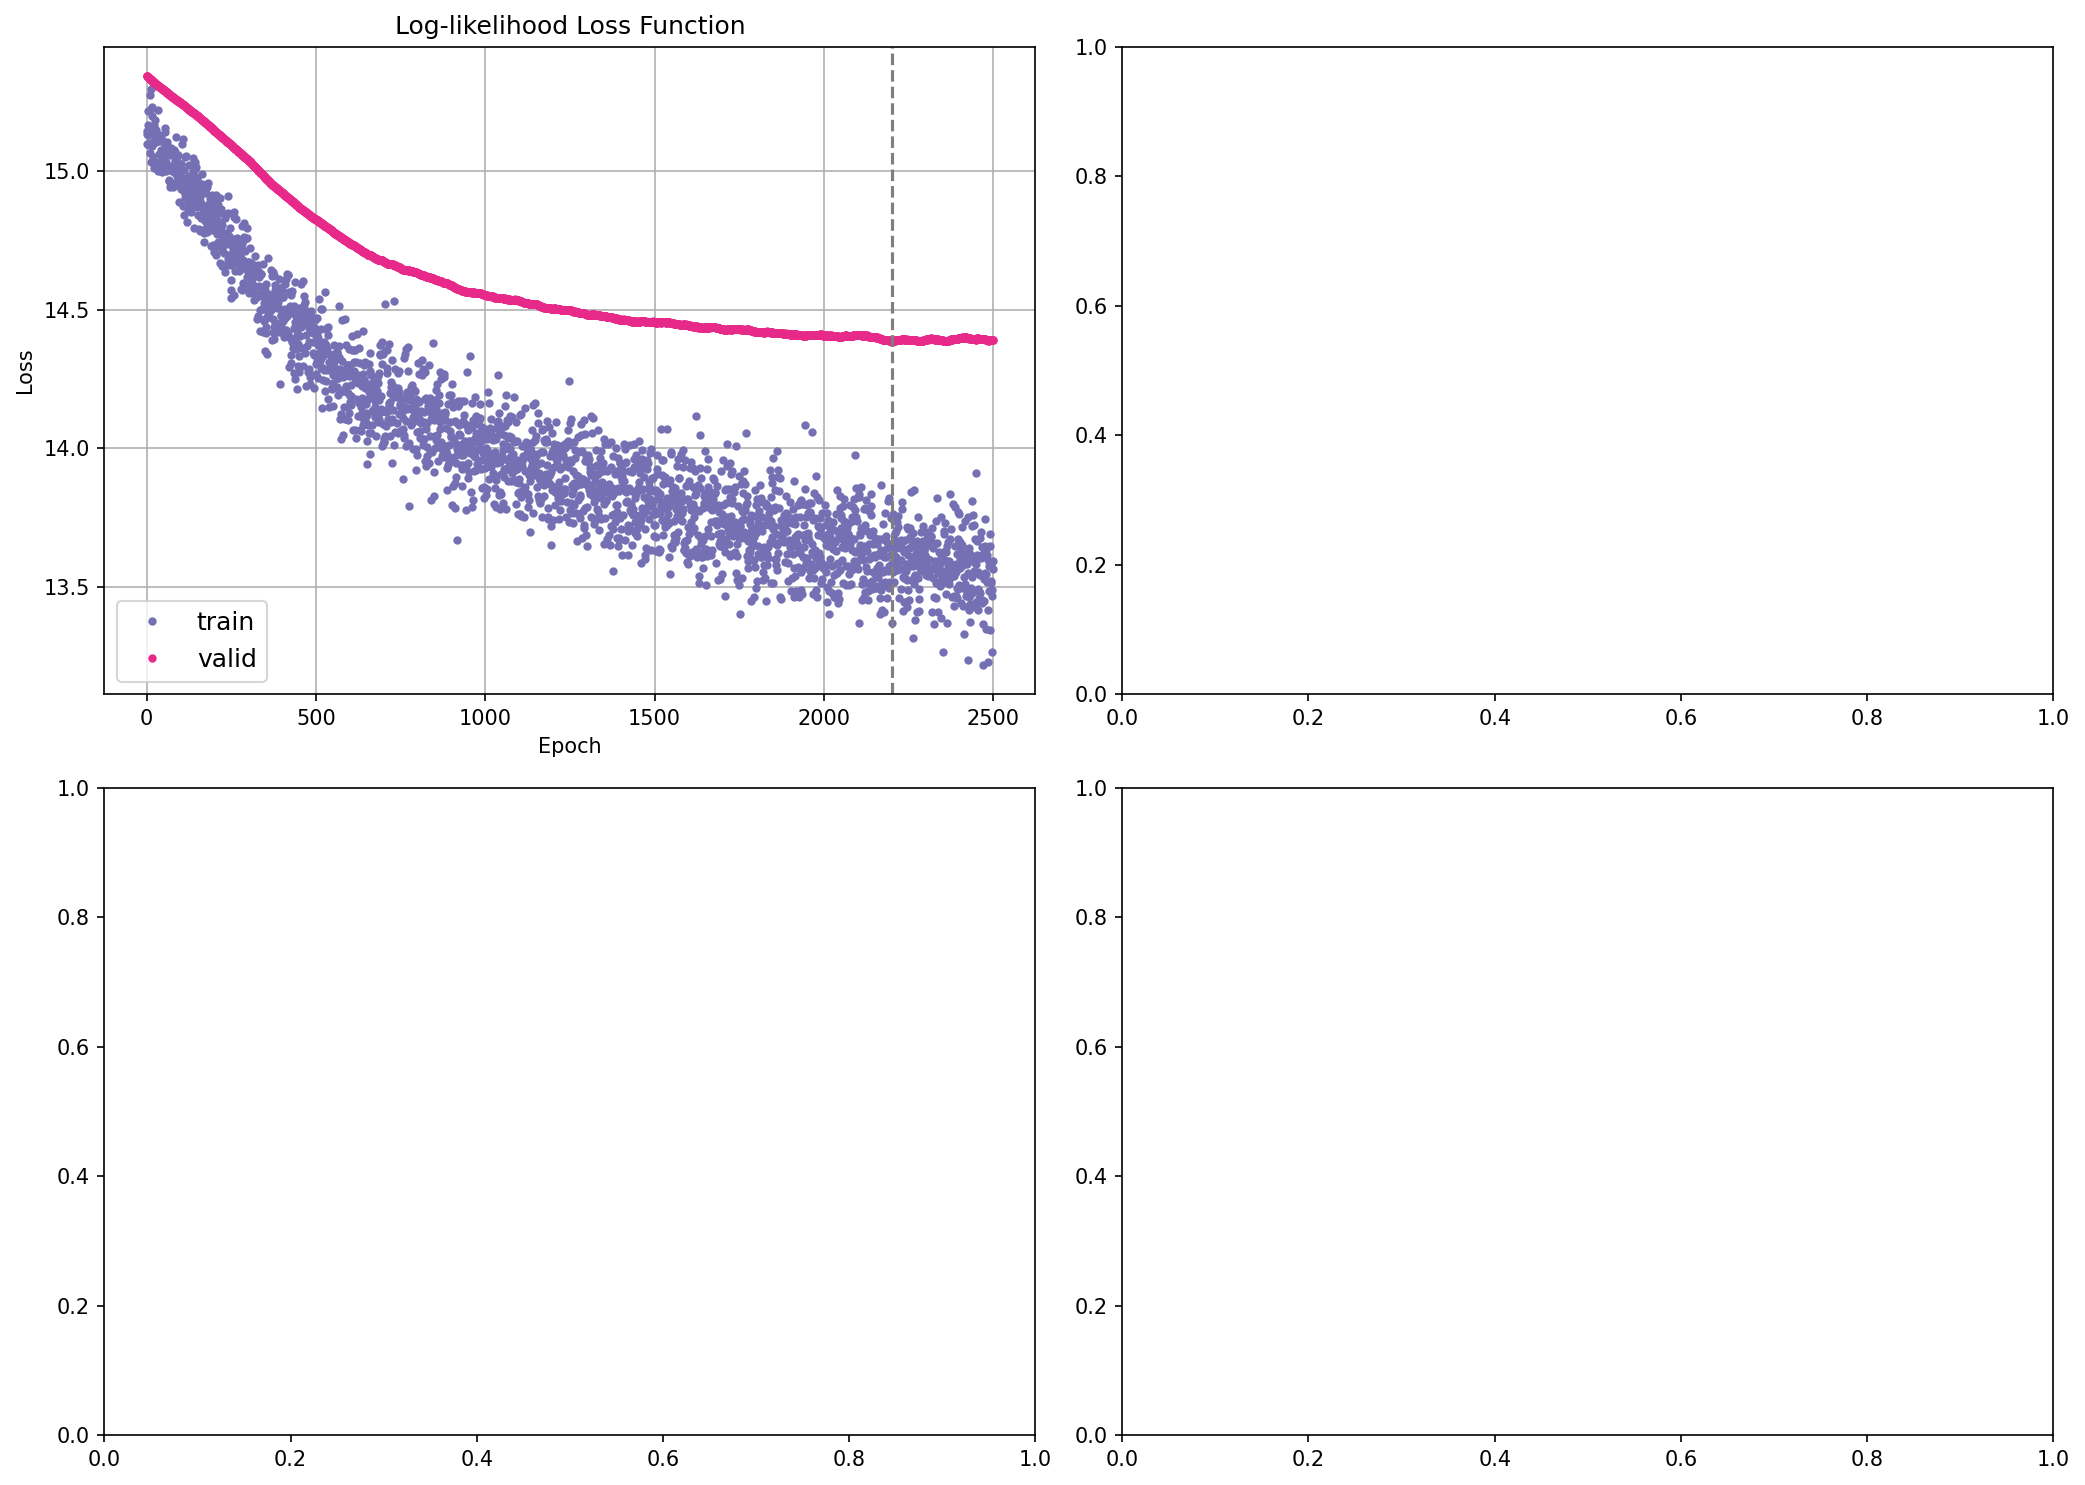

In [4]:
for EXP_NAME in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(EXP_NAME)
    # pprint.pprint(settings, width=80)

    RNG_SEED_LIST = np.copy(settings['rng_seed'])
    # NETWORK_SEED_LIST = [1701, 5552, 8529, 4440, 2657,] # currently over-written later in this script

    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        # pprint.pprint(settings['rng_seed'], width=80)

        # build the intensity data tensors
        (
            x_train,
            onehot_train,
            x_val,
            onehot_val,
            x_eval,
            onehot_eval,    
            data_summary,
            df_val,
            df_eval,
        ) = build_hurricane_data(DATA_PATH, settings, verbose=2)

        # define the callbacks
        earlystoping_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=settings["patience"],
            restore_best_weights=True,
            verbose=1,
        )

        training_callback = TrainingInstrumentation(
            x_train,
            onehot_train,
            interval=50,
        )

        callbacks = [earlystoping_callback, training_callback]

        # set network seed and train the model
        NETWORK_SEED_LIST = [settings["rng_seed"]]

        for network_seed in NETWORK_SEED_LIST:
            tf.random.set_seed(network_seed)  # This sets the global random seed.

            # Create the model name.
            model_name = (
                EXP_NAME + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )
            pprint.pprint(model_name)

            # Make, compile, and train the model
            tf.keras.backend.clear_session()

            if settings["uncertainty_type"] == "bnn":       
                model = build_bnn_model(
                    x_train,
                    onehot_train,
                    hiddens=settings["hiddens"],
                    output_shape=onehot_train.shape[1],
                    ridge_penalty=settings["ridge_param"],
                    act_fun=settings["act_fun"],
                )        

                model.compile(
                    optimizer=optimizers.Adam(
                        learning_rate=settings["learning_rate"],
                    ),
                    loss=compute_NLL,
                )   
            elif settings["uncertainty_type"] == "mcdrop":  
                model = build_mcdrop_model(
                    x_train,
                    onehot_train,
                    dropout_rate=settings["dropout_rate"],
                    hiddens=settings["hiddens"],
                    output_shape=onehot_train.shape[1],
                    ridge_penalty=settings["ridge_param"],
                    act_fun=settings["act_fun"],
                    # rng_seed=settings['rng_seed'],
                )        

                model.compile(
                    optimizer=optimizers.Adam(
                        learning_rate=settings["learning_rate"],
                    ),
                    loss='mae',
                )   

            elif settings["uncertainty_type"][:5] == "shash":   
                model = build_shash_model(
                    x_train,
                    onehot_train,
                    hiddens=settings["hiddens"],
                    output_shape=onehot_train.shape[1],
                    ridge_penalty=settings["ridge_param"],
                    act_fun=settings["act_fun"],
                )

                model.compile(
                    optimizer=optimizers.SGD(
                        learning_rate=settings["learning_rate"],
                        momentum=settings["momentum"],
                        nesterov=settings["nesterov"],
                    ),
                    loss=compute_shash_NLL,
                    metrics=[
                        CustomMAE(name="custom_mae"),
                        InterquartileCapture(name="interquartile_capture"),
                        SignTest(name="sign_test"),
                    ],
                )


            model.summary()

            # check if the model exists
            model_savename = MODEL_PATH + model_name + "_weights.h5"
            if os.path.exists(model_savename) and OVERWRITE_MODEL==False:
                print(model_savename + 'exists. Skipping...')
                continue

            # train the network
            start_time = time.time()
            history = model.fit(
                x_train,
                onehot_train,
                validation_data=(x_val, onehot_val),
                batch_size=settings["batch_size"],
                epochs=settings["n_epochs"],
                shuffle=True,
                verbose=0,
                callbacks=callbacks,
            )
            stop_time = time.time()

            # Display the results, and save the model rum.
            best_epoch = np.argmin(history.history["val_loss"])
            fit_summary = {
                "network_seed": network_seed,
                "elapsed_time": stop_time - start_time,
                "best_epoch": best_epoch,
                "loss_train": history.history["loss"][best_epoch],
                "loss_valid": history.history["val_loss"][best_epoch],
            }
            pprint.pprint(fit_summary, width=80)
            plot_history(history, model_name)

            save_model_run(
                data_summary,
                fit_summary,
                model,
                MODEL_PATH,
                model_name,
                settings,
                __version__,
            )